# Autoregressive (AR) HMM Demo

This notebook demonstrates how to construct and fit a linear autoregressive HMM.
Let $y_t$ denote the observation at time $t$. Let $z_t$ denote the corresponding discrete latent state.

The autoregressive hidden Markov model has the following likelihood,

\begin{align*}
y_t \mid y_{t-1}, z_t &\sim
\mathcal{N}\left(A_{z_t} y_{t-1} + b_{z_t}, Q_{z_t} \right).
\end{align*}

(Higher-order autoregressive processes are also supported.) 

This notebook will also show how inputs are passed into SSMs in Dynamax.

## Setup

In [1]:
from scipy import io
from pathlib import Path
import numpy as np
import matplotlib.patches as mpatches

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

### Helper functions for plotting

In [3]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [30]:
def plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors):
    
    plot_slice = (0, 300)
    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)
    # lim = 1

    plt.figure(figsize=(8, 6))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(211)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors)-1,
        extent=(0, time_bins, -lim, (emission_dim)*lim)
    )

    values = np.unique(most_likely_states.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="State {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')

    plt.xlim(plot_slice)
    plt.yticks([+1, 0, -1])


    # Plot number 2
    plt.subplot(212)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=range(state_probability_spread.shape[0]))
    plt.xlabel("time")

    plt.show()

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

## RNN DATA

In [5]:
rnn_dirs = sorted(Path("../rnns/").iterdir())

def load_rnn(rnn_dirs, rnn_num):
    trial = io.loadmat(rnn_dirs[rnn_num * 2 - 1])
    return trial['test_out']

In [6]:
choices = load_rnn(rnn_dirs, 1)

observations = choices.reshape(-1, 300, 1)
# choices_binarized
# model_choices = (choices[:,:,-50:].mean(axis=2) > 0.5).astype(int).reshape(1,-1,1) 
# model_choices.shape

In [7]:
choices.shape, observations.shape

((4, 50, 300), (200, 300, 1))

## Manually construct an ARHMM

In [8]:
emissions = observations

inputs = np.zeros_like(emissions)
inputs[:,1:,:] = emissions[:,:-1,:]

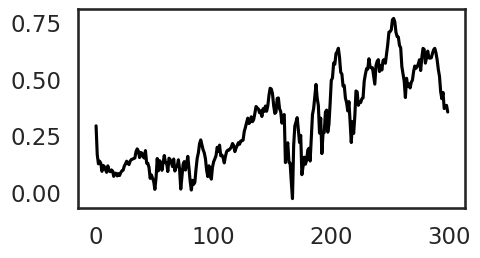

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(emissions[0,:,0], '-k')
plt.tight_layout()

## Train Test Split

In [10]:
r_indexes = np.arange(len(emissions))
np.random.shuffle(r_indexes)

emissions = emissions[r_indexes]
inputs = inputs[r_indexes]

emissions.shape, inputs.shape

((200, 300, 1), (200, 300, 1))

In [11]:
train_emissions = emissions[:150]
train_inputs = inputs[:150]

test_emissions = emissions[150:]
test_inputs = inputs[150:]

train_emissions.shape, train_inputs.shape, test_emissions.shape, test_inputs.shape

((150, 300, 1), (150, 300, 1), (50, 300, 1), (50, 300, 1))

## Fit an ARHMM

In [12]:
def train_arhmm(num_states, emission_dim, num_lags, train_emissions, train_inputs):
    # Initialize with K-Means
    arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
    params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=train_emissions)

    # Fit with EM
    fitted_params, lps = arhmm.fit_em(params, props, train_emissions, inputs=train_inputs, num_iters=200, verbose=False)

    return arhmm, fitted_params, lps

In [13]:
# num_states = 3
emission_dim = 1
num_lags = 1

all_models, all_params, all_lps = [], [], []

for num_states in range(2, 10):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, num_lags, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)

Training: 2 states
Training: 3 states
Training: 4 states
Training: 5 states
Training: 6 states
Training: 7 states
Training: 8 states
Training: 9 states


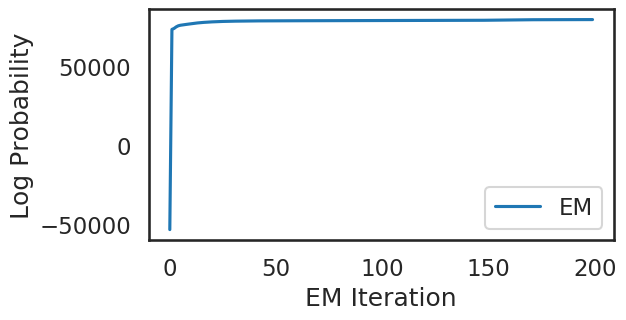

In [31]:
plot_lps(all_lps[3])

In [56]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

In [57]:
cross_valids = cross_validate(all_models, all_params, test_emissions, test_inputs)
cross_train = cross_validate(all_models, all_params, train_emissions, train_inputs)

Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model
Cross Validating: 5 model
Cross Validating: 6 model
Cross Validating: 7 model
Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model
Cross Validating: 5 model
Cross Validating: 6 model
Cross Validating: 7 model


### Plot optimal states from validation


In [75]:
def plot_validation(cross_valids, show_var = True):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, 10), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, 10), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, 10))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    plt.show()

In [ ]:
plot_validation(cross_valids=cross_valids, show_var=False)

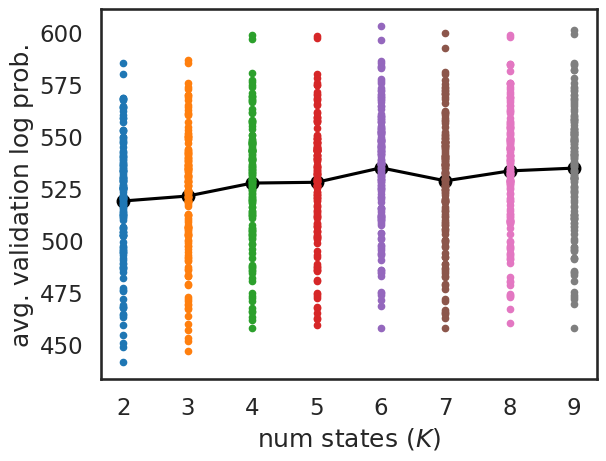

In [63]:
plot_validation(cross_valids=cross_train)

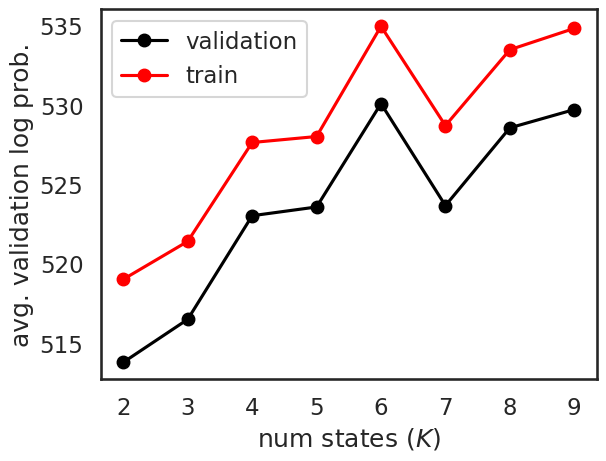

In [85]:
avg_val_lls = cross_valids.mean(axis=1)
plt.plot(range(2, 10), avg_val_lls, '-ko', label = 'validation')
plt.plot(range(2, 10), cross_train.mean(axis=1), '-ro', label = 'train')
plt.xticks(range(2, 10))
plt.legend()
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.show()

### Find the most likely states and Plot inferred discrete states

In [64]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    # posterior.smoothed_probs.T.shape, most_likely_states.shape
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

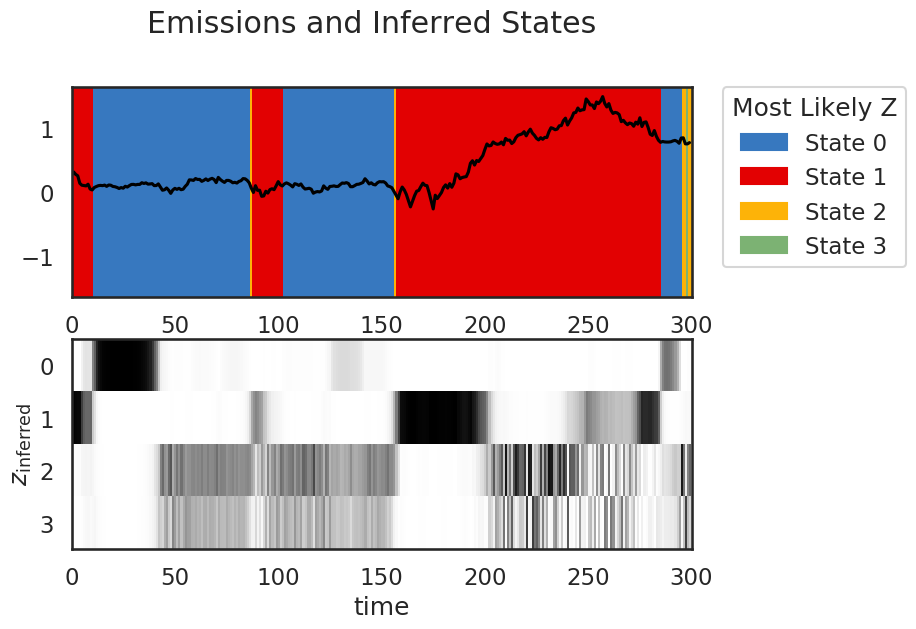

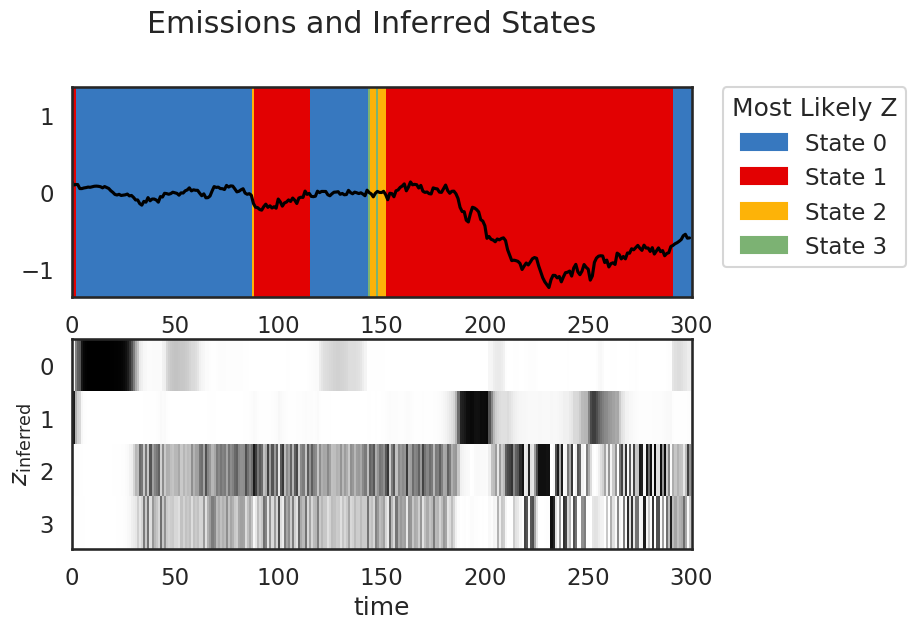

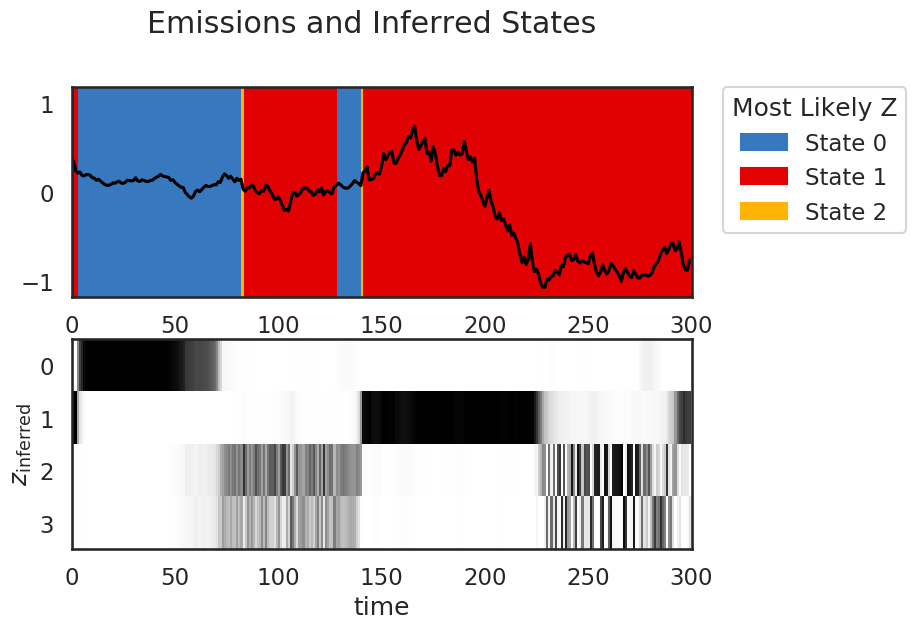

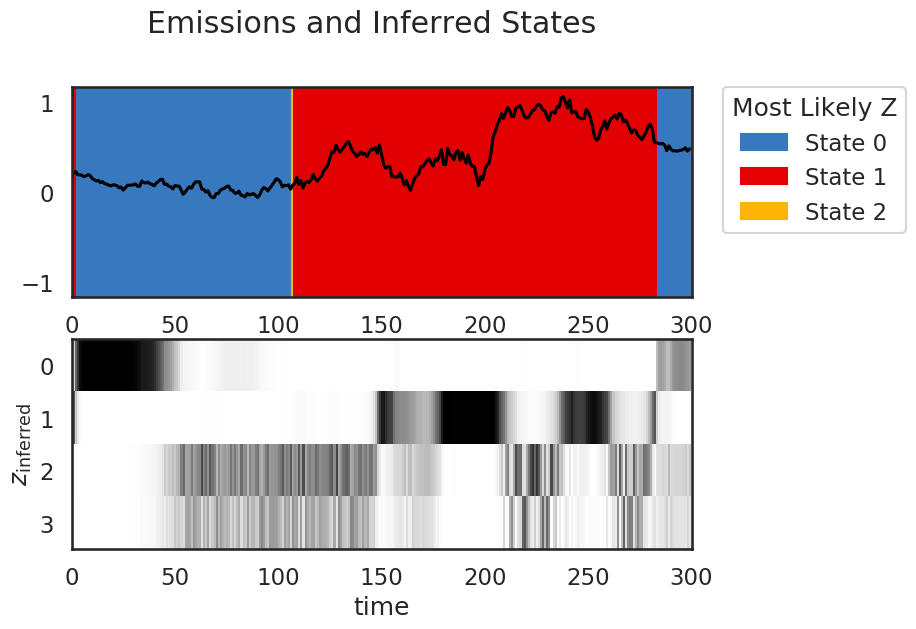

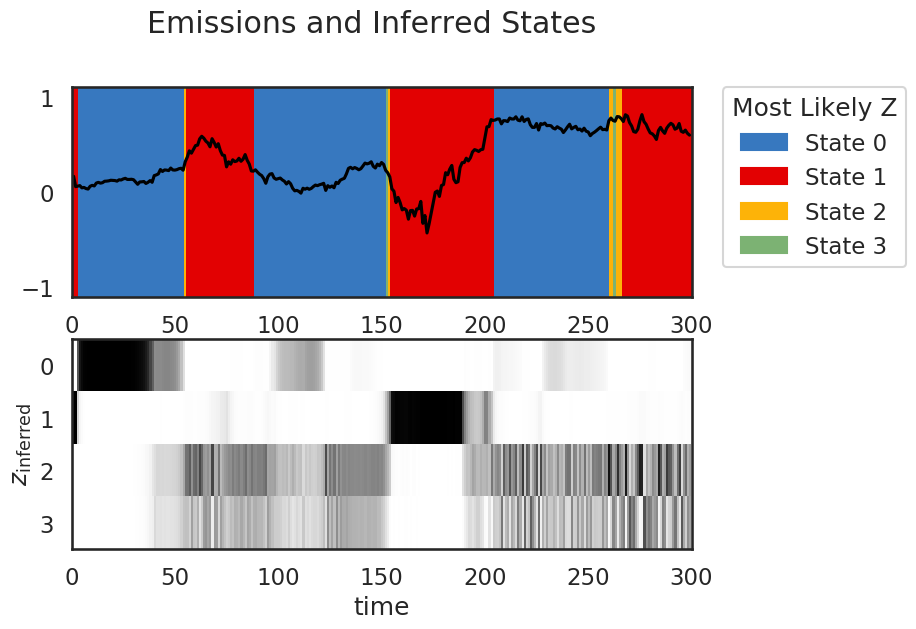

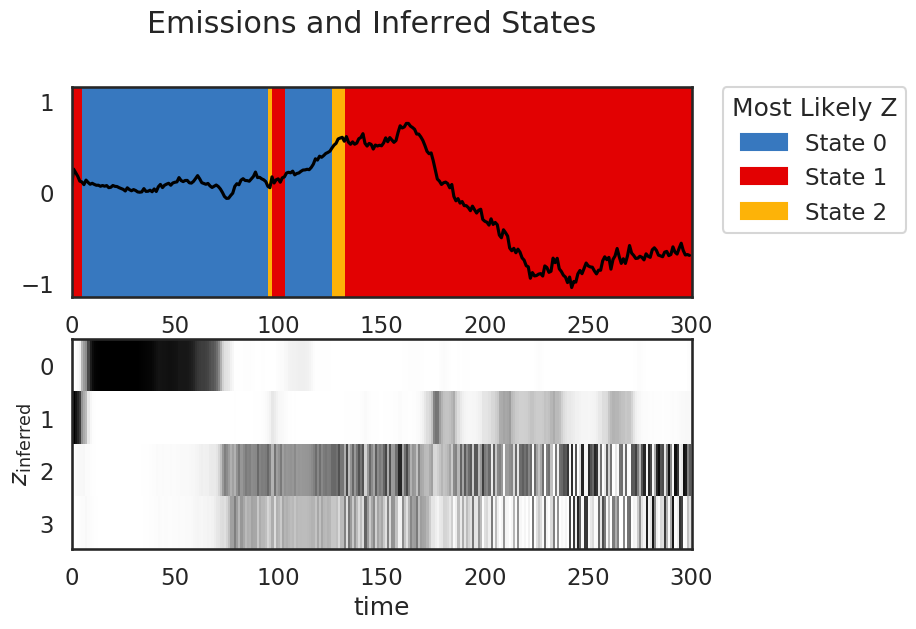

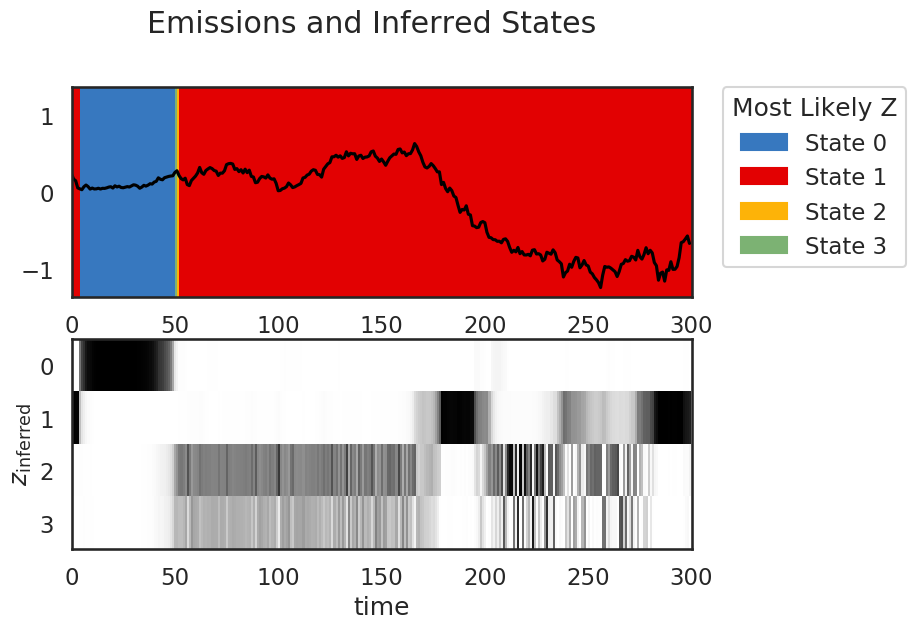

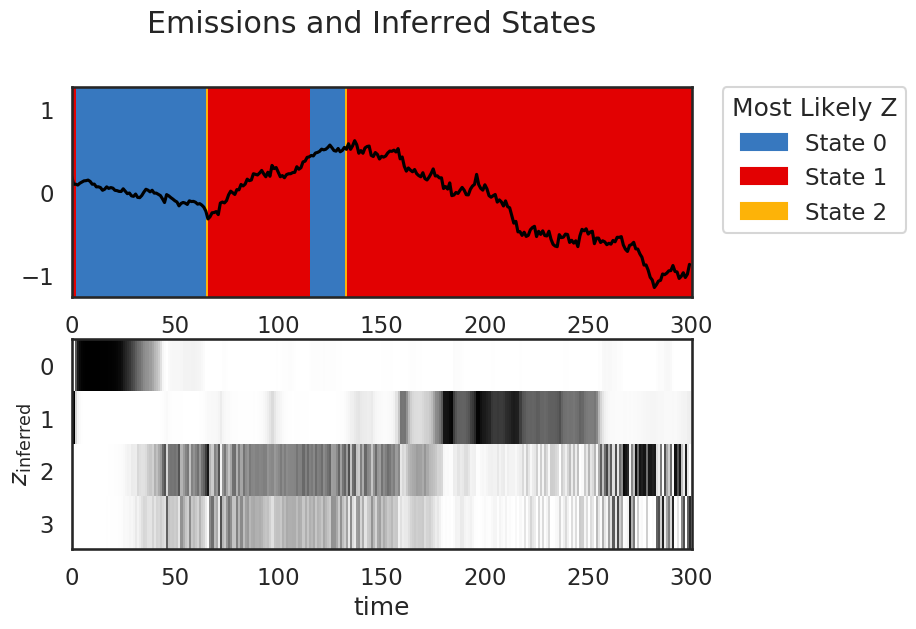

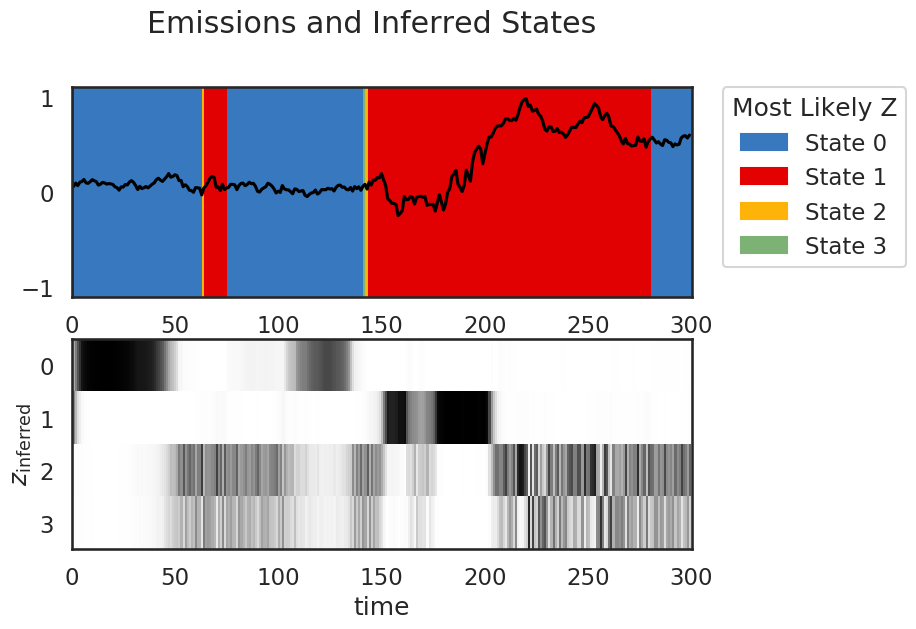

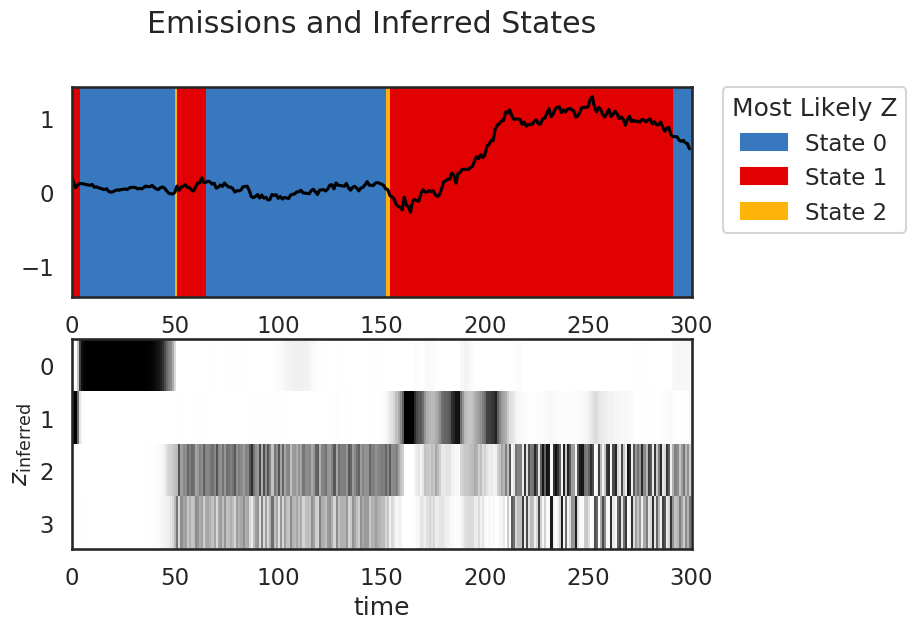

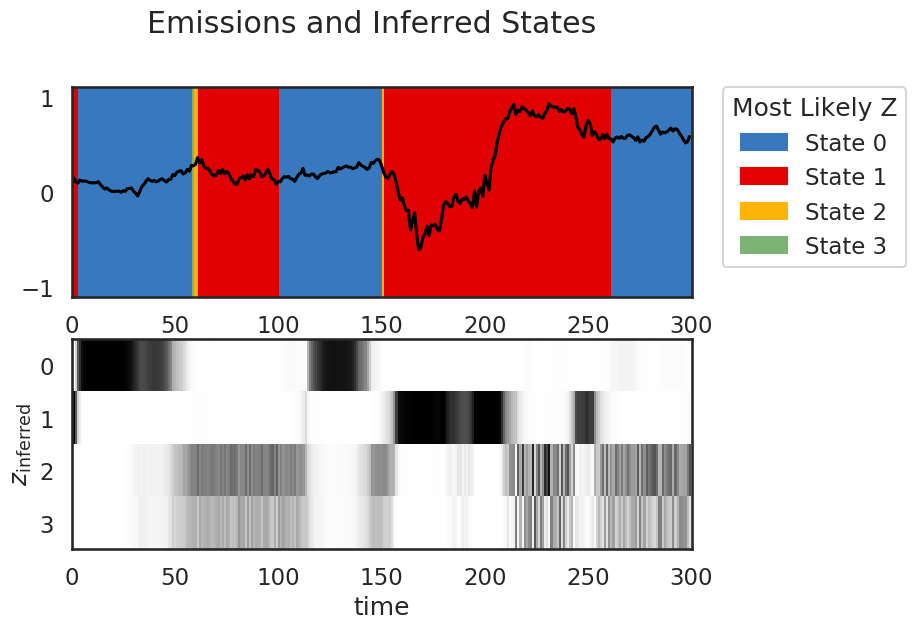

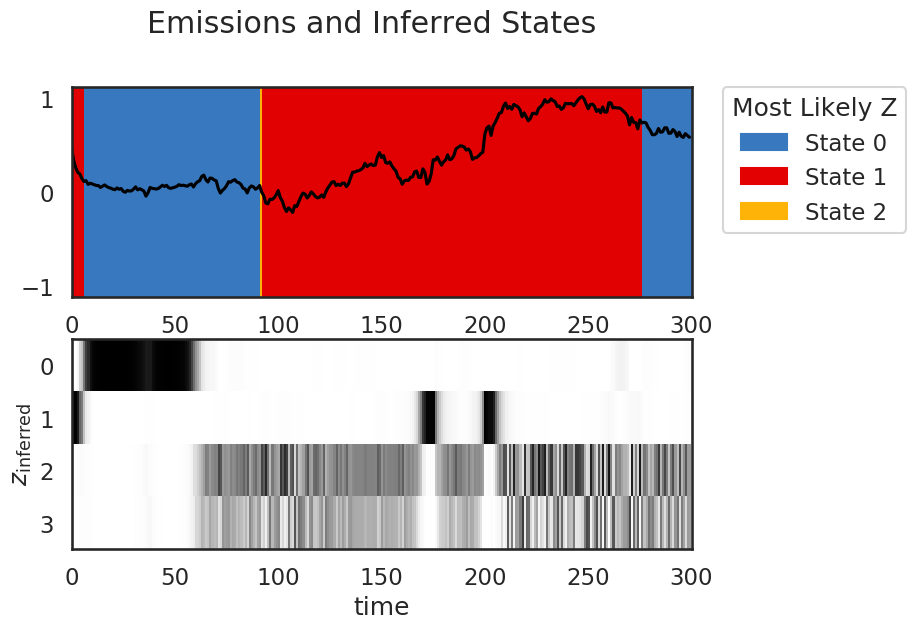

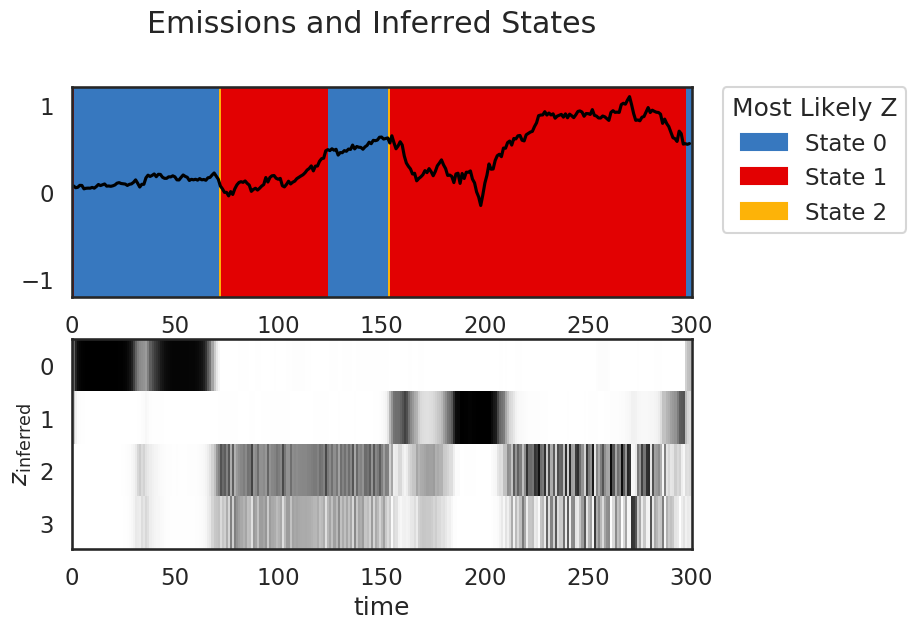

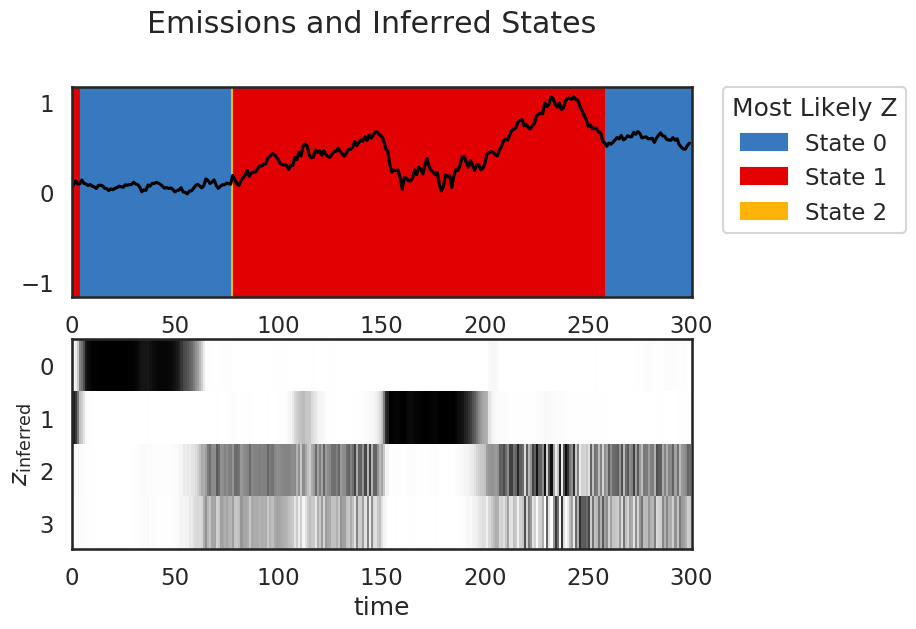

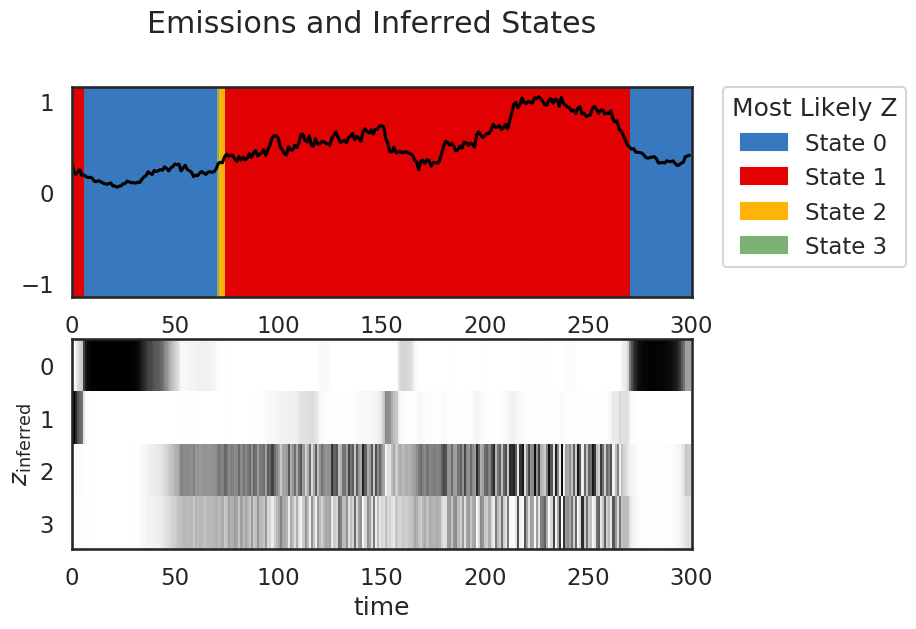

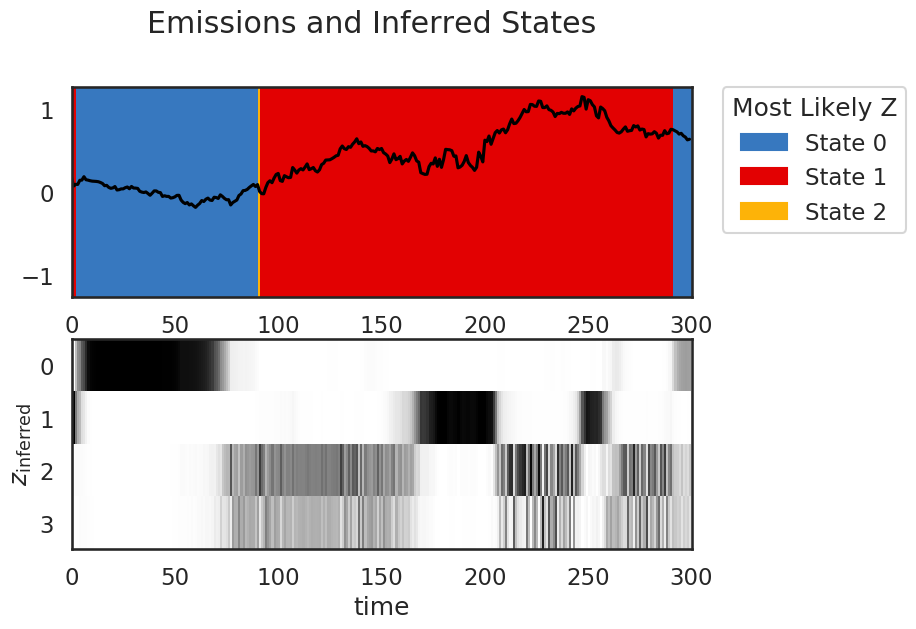

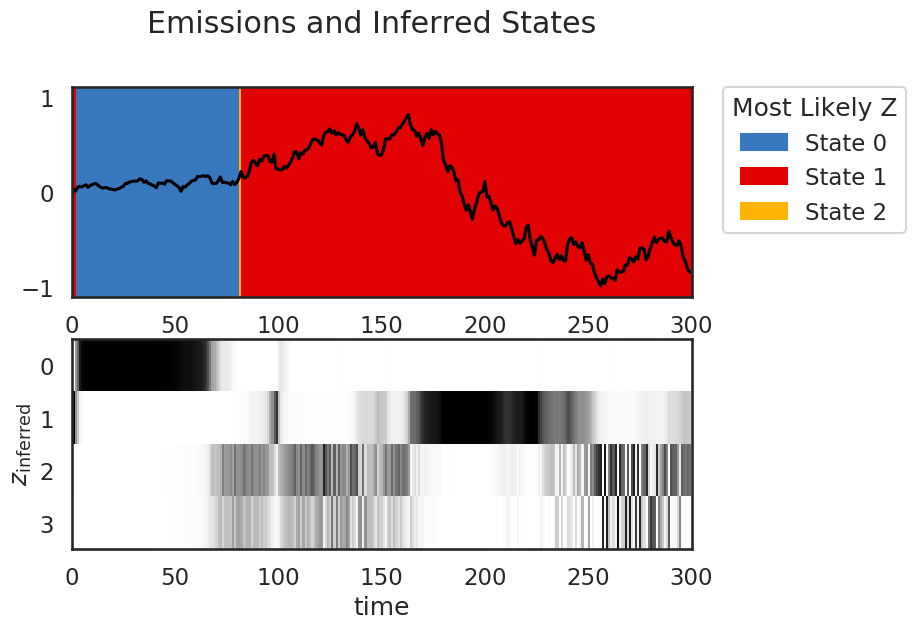

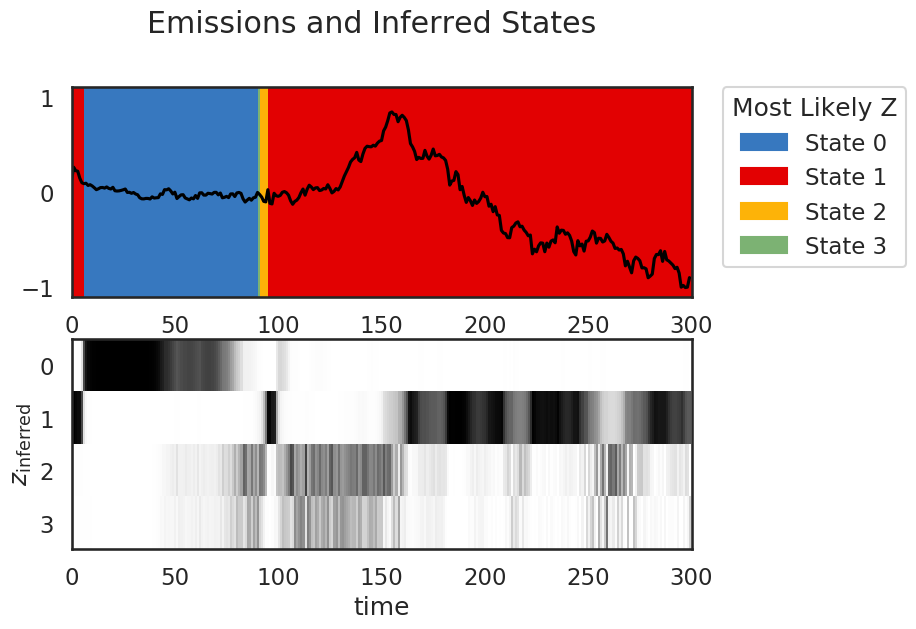

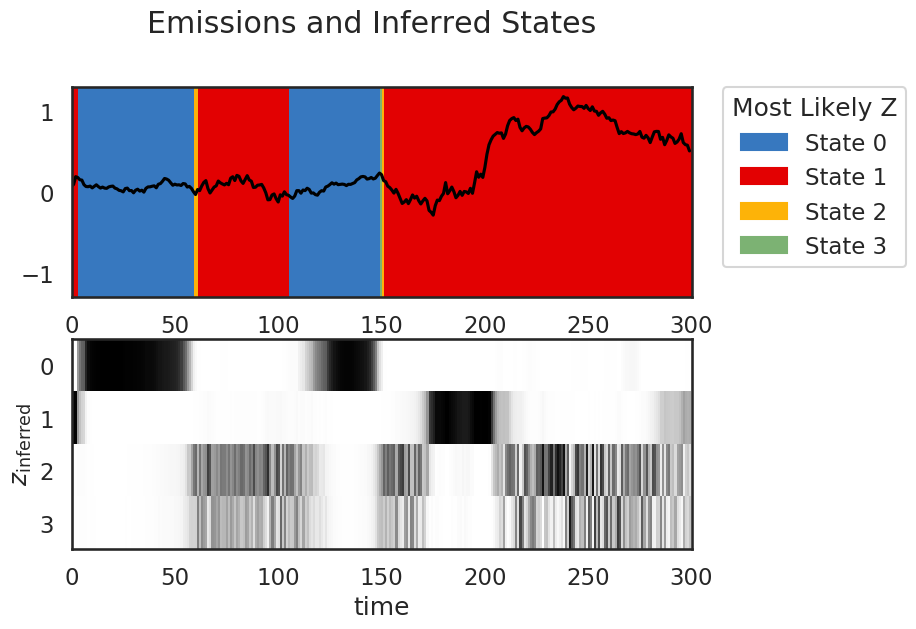

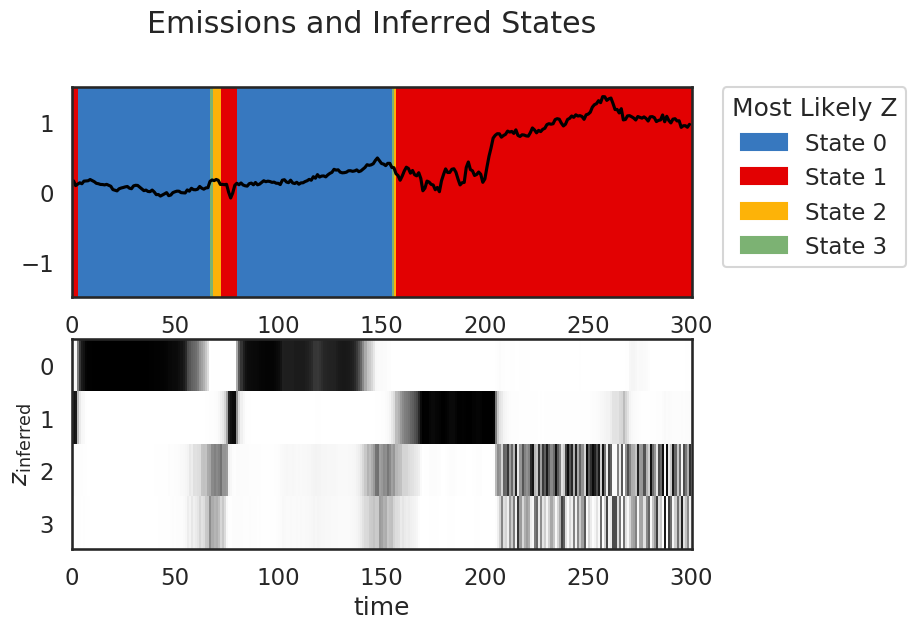

In [87]:
states = 4

for i in range(20):
    inspect_sample(states - 2, i)